In [1]:
from models.nac import NAC
import torch.nn.functional as F
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm_notebook as tqdm

from data_generator_helper import generate_synthetic_selection_dataset

import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

from torch.nn.parameter import Parameter

In [50]:
from torch.nn import MSELoss as MSE

def test(model, x_test, y_test):
    loss = nn.MSELoss()
    model.eval()
    output_test = model(x_test)
    loss = loss(output_test, y_test)
    
    return loss

In [54]:
weightfile = 'convtest_NALU_Kai_uni_test_7.npy'
weights, losses, bounds, sample_size, out_dim, epochs, its, g_prevs = np.load(weightfile)
temp = weights[0][0][-1,-1,:,:,:]
W_hat = temp[:,:,0]
M_hat = temp[:,:,1]
W = temp[:,:,2]
G = temp[:,:,3]


In [55]:
class NeuralAccumulatorCell(nn.Module):
    """A Neural Accumulator (NAC) cell [1].

    Attributes:
        in_dim: size of the input sample.
        out_dim: size of the output sample.

    Sources:
        [1]: https://arxiv.org/abs/1808.00508
    """
    def __init__(self, What, Mhat):
        super().__init__()


        self.What = What#Parameter(torch.Tensor(out_dim, in_dim))
        self.Mhat = Mhat#Parameter(torch.Tensor(out_dim, in_dim))

        self.register_parameter('W_hat', self.What)
        self.register_parameter('M_hat', self.Mhat)
        self.register_parameter('bias', None)

    def forward(self, input):
        W = torch.tanh(self.What) * torch.sigmoid(self.Mhat)
        return F.linear(input, W, self.bias)


class NeuralArithmeticLogicUnitCell(nn.Module):
    """A Neural Arithmetic Logic Unit (NALU) cell [1].

    Attributes:
        in_dim: size of the input sample.
        out_dim: size of the output sample.

    Sources:
        [1]: https://arxiv.org/abs/1808.00508
    """
    def __init__(self, G, What, Mhat):
        super().__init__()

        self.eps = 1e-10

        self.G = G
        self.nac = NeuralAccumulatorCell(What, Mhat)
        self.register_parameter('bias', None)
    

    def forward(self, input):

        a = self.nac(input)
        g = torch.sigmoid(F.linear(input, self.G, self.bias))

        add_sub = g * a
        log_input = torch.log(torch.abs(input) + self.eps)

        m = torch.exp(self.nac(log_input))

        mul_div = (1 - g) * m
        y = add_sub + mul_div
        return y


In [56]:
G[0,0],type(G[0,0])

(0.41705361008644104, numpy.float64)

In [57]:
G = torch.Tensor(G)
G = torch.nn.Parameter(G.type(torch.DoubleTensor))
W_hat = torch.Tensor(W_hat)
W_hat = torch.nn.Parameter(W_hat.type(torch.DoubleTensor))
M_hat = torch.Tensor(M_hat)
M_hat = torch.nn.Parameter(M_hat.type(torch.DoubleTensor))

model = NeuralArithmeticLogicUnitCell(G, W_hat, M_hat)

In [58]:
np.shape(G), np.shape(W_hat), np.shape(M_hat)

(torch.Size([2, 100]), torch.Size([2, 100]), torch.Size([2, 100]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: overflow encountered in exp
  """


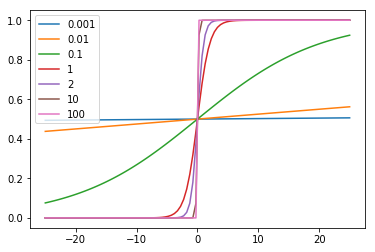

In [22]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x,t):
    y = 1/ (1 + np.exp(-t*x))
    return y

ts = [0.001,0.01, 0.1, 1, 2, 10,100]
x = np.linspace(-25,25,100)
for t in ts:

    y = sigmoid(x,t)

    plt.plot(x,y,'-', label=str(t))
plt.legend()
plt.show()

In [60]:
test_per_range = 1
sample_size = 100
set_size = 100

in_dim = sample_size
hidden_dim = 1
out_dim = 2
num_layers = 1

lr = 0.01
epochs = 1000


#values = np.linspace(1,1000,10)
values = [[0.0,1.0],
          [-0.001, 0.001]
          [0.0,100.0],
          [-100.0,100.0],
          [-1000.0,1000.0],
          [-1.0,1.0]]

for value in values:
    min_value, max_value=  value

    x_test, y_test, _ = generate_synthetic_selection_dataset(min_value, max_value,
                                                                sample_size, set_size, boundaries = bounds[0][0])

    x_test = x_test.type(torch.DoubleTensor)
    y_test = y_test.type(torch.DoubleTensor)
    test_loss  = test(model, x_test, y_test)

    print(float(test_loss.data.numpy())/torch.max(x_test).numpy())


2.313422530696826e-08
1.6285113061663777e-06
-2.740164469700694e+50
2.781212102290671e+112
2.5328427721911637e+180
4.009780210373312
